In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

## 데이터 필드
id  - 생물의 ID

bone_length - 생물체의 뼈의 평균 길이. 0에서 1 사이의 정규화 된 값.

rotting_flesh  - 생물의 썩은 살의 비율

hair_length - 평균 머리 길이, 0에서 1 사이의 정규화

has_soul  - 생물체 내의 영혼의 비율

color - 지배적 인 색 : '흰색', '검은 색', '맑은', '푸른 색', '녹색', '피'

type  - 대상 변수 : 'Ghost', 'Goblin', 'Ghoul'

In [2]:
train.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost


In [3]:
test.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color
0,3,0.471774,0.387937,0.706087,0.698537,black
1,6,0.427332,0.645024,0.565558,0.451462,white
2,9,0.549602,0.491931,0.660387,0.449809,black
3,10,0.638095,0.682867,0.471409,0.356924,white
4,13,0.361762,0.583997,0.377256,0.276364,black


In [4]:
train.shape

(371, 7)

In [5]:
test.shape

(529, 6)

In [6]:
print(np.sort(train['color'].unique()))

['black' 'blood' 'blue' 'clear' 'green' 'white']


In [7]:
def chart(feature):
    ghoul = train[train['type']=='Ghoul'][feature].value_counts()
    goblin = train[train['type']=='Goblin'][feature].value_counts()
    ghost = train[train['type']=='Ghost'][feature].value_counts()
    df = pd.DataFrame([ghoul,goblin,ghost])
    df.index = ['Ghoul','Goblin','Ghost']
    df.plot(kind='bar',stacked=True, figsize=(10,5))

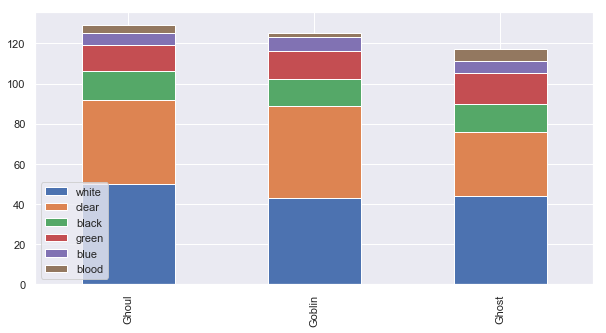

In [8]:
chart('color')

In [9]:
train = train.drop(['color'],axis=1)
test = test.drop(['color'],axis=1)

C:\Users\start\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


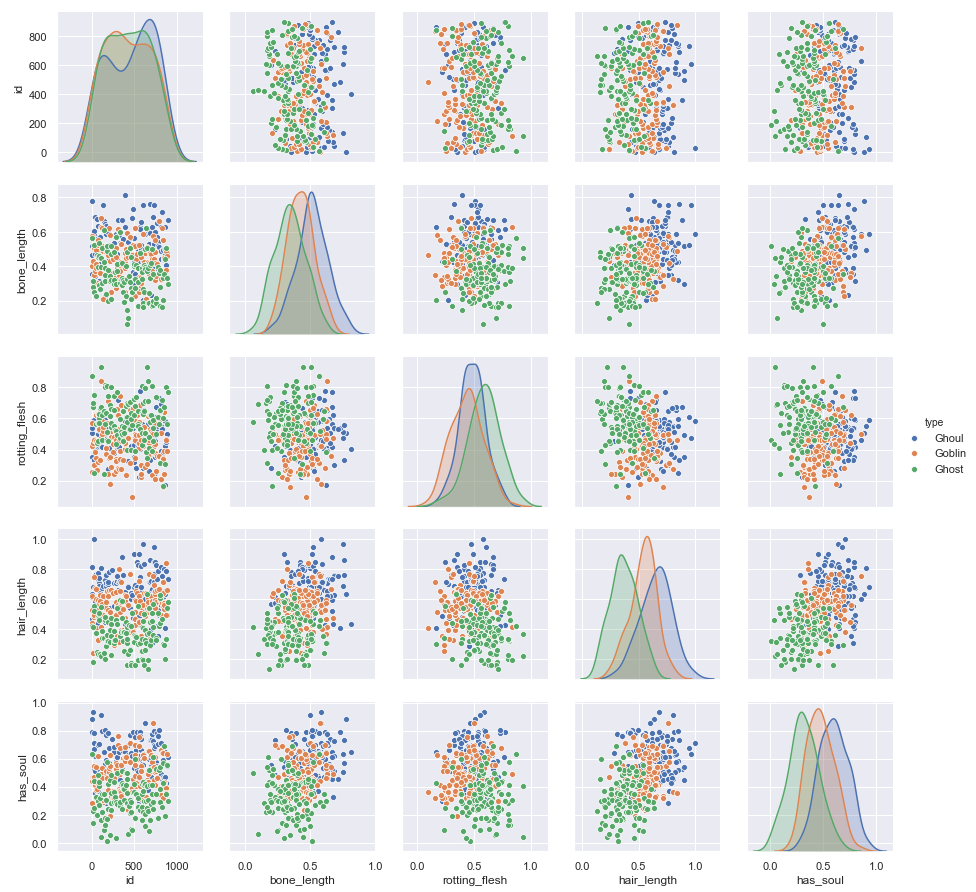

In [10]:
sns.pairplot(train,hue="type")

In [50]:
train['br'] = train.apply(lambda row: row['bone_length']+row['rotting_flesh'],axis=1)
train['bh'] = train.apply(lambda row: row['bone_length']+row['hair_length'],axis=1)
train['bs'] = train.apply(lambda row: row['bone_length']+row['has_soul'],axis=1)
train['rh'] = train.apply(lambda row: row['rotting_flesh']+row['hair_length'],axis=1)
train['rs'] = train.apply(lambda row: row['rotting_flesh']+row['has_soul'],axis=1)
train['hs'] = train.apply(lambda row: row['hair_length']+row['has_soul'],axis=1)

test['br'] = test.apply(lambda row: row['bone_length']+row['rotting_flesh'],axis=1)
test['bh'] = test.apply(lambda row: row['bone_length']+row['hair_length'],axis=1)
test['bs'] = test.apply(lambda row: row['bone_length']+row['has_soul'],axis=1)
test['rh'] = test.apply(lambda row: row['rotting_flesh']+row['hair_length'],axis=1)
test['rs'] = test.apply(lambda row: row['rotting_flesh']+row['has_soul'],axis=1)
test['hs'] = test.apply(lambda row: row['hair_length']+row['has_soul'],axis=1)

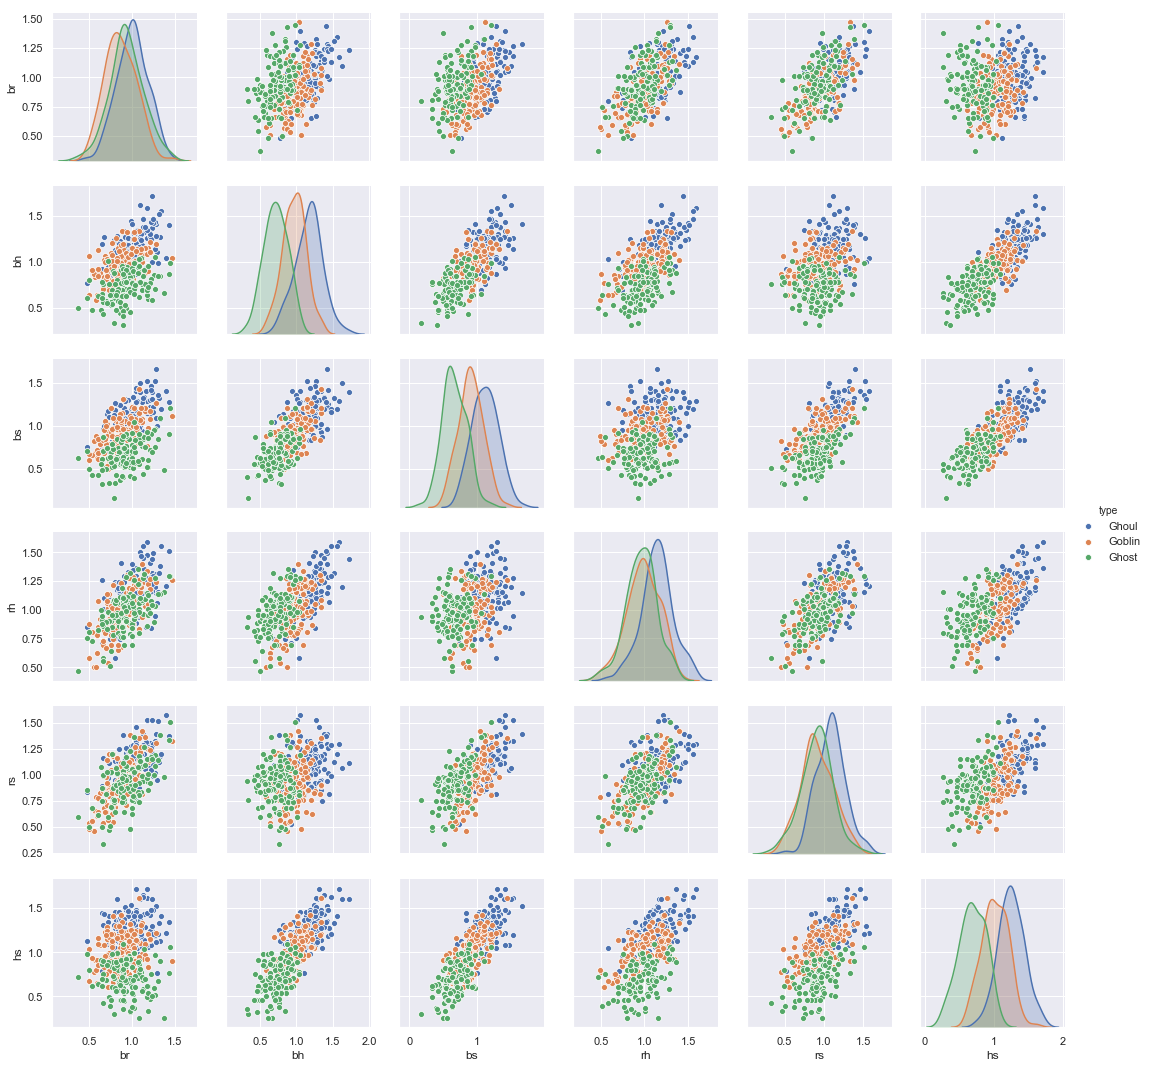

In [51]:
sns.set()
sns.pairplot(train[["br","bh","bs","rh","rs","hs","type"]], hue="type")

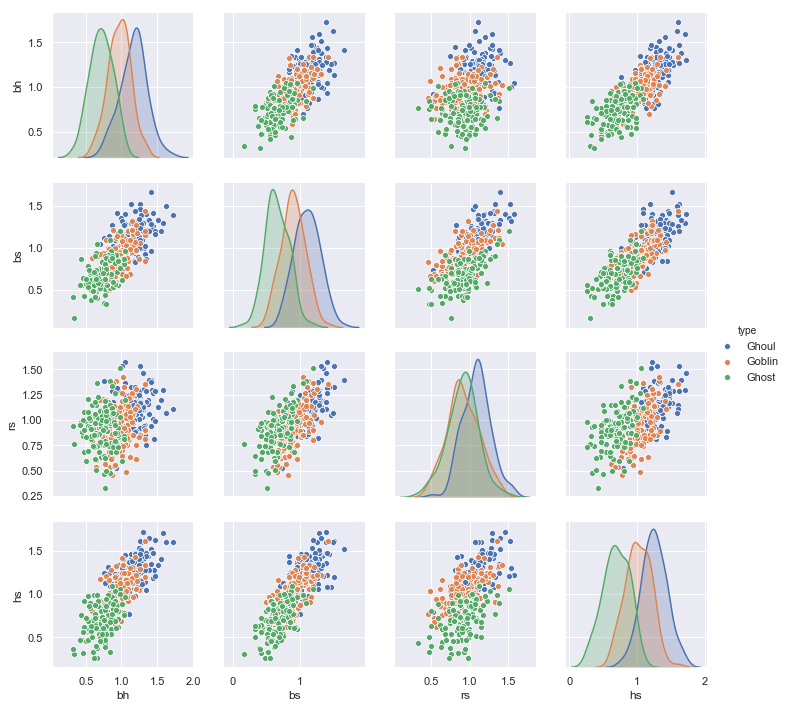

In [52]:
sns.set()
sns.pairplot(train[["bh","bs","rs","hs","type"]], hue="type")

In [33]:
from sklearn import linear_model
from sklearn import neighbors
from sklearn import ensemble
from sklearn import svm
from sklearn import naive_bayes
from sklearn.model_selection import GridSearchCV

In [34]:
x_train = train[["bh","bs","rs","hs"]]
y = train[["type"]]

x_test = test[["bh","bs","rs","hs"]]

In [35]:
clfs = {}
clfs['nb'] = {'clf': naive_bayes.GaussianNB(), 'name':'GaussianNaiveBayes'}
clfs['gbc'] = {'clf': ensemble.GradientBoostingClassifier(), 'name': 'GradientBoostingClassifier'}

In [36]:
parameters = {'kernel':['linear', 'sigmoid', 'poly', 'rbf'], 'gamma':np.linspace(0.0,2.0,num=21),'C': np.linspace(0.5,1.5,num=11)}
clfs['svcgrid'] = {'clf': GridSearchCV(svm.SVC(), parameters), 'name': 'SVC with GridSearch'}

parameters = {'C':[1],'tol':[0.0001],'solver': ['newton-cg'], 'multi_class': ['multinomial']}
clfs['lrgrid'] = {'clf': GridSearchCV(linear_model.LogisticRegression(), parameters), 'name': 'LogisticRegression with GridSearch'}

In [37]:
clfs['data'] = {'clf': ensemble.VotingClassifier(estimators=[
            ('svcgrid', clfs['svcgrid']['clf']),
            ('lrgrid', clfs['lrgrid']['clf']),
            ('gbc', clfs['gbc']['clf'])
        ], voting='hard'), 'name': 'VotingClassifierHairSoul'}

In [38]:
clfs['data']['clf'] = clfs['data']['clf'].fit(x_train, y.values.ravel())

C:\Users\start\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\start\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\start\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [39]:
clfs['data']['predictions'] = clfs['data']['clf'].predict(x_test)

In [40]:
sub = pd.DataFrame(clfs['data']['predictions'])
pd.concat([test["id"],sub], axis=1).rename(columns = {0: 'type'}).to_csv("testset_predict6.csv", index=False)